In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from ncps.wirings import AutoNCP
from ncps.torch import LTC
from sklearn.model_selection import train_test_split

from state_representation import ImageDataset, CombineTransform, \
    NormalizeTransform, TransposeTransform, record_resets
from utils.config import AE_CONFIG

# Data collection and preprocessing

In [3]:
IMAGE_PATH = "./state_representation/reset_image_data_agent"
LABEL_PATH = "./state_representation/reset_label_data_agent"
BATCH_SIZE = 16

#### Record images of the environment including agent, target and static / dynamic obstacles

In [ ]:
record_resets(IMAGE_PATH, 10000, AE_CONFIG.env)

#### Load data from disk into memory

In [4]:
transform = CombineTransform([
    NormalizeTransform(start=(0, 255), end=(0, 1)),
    # TransposeTransform(-3, -1)
])

dataset = ImageDataset(IMAGE_PATH, LABEL_PATH, transform=transform)

#### Create and save labels on disk

NOTE: This will override existing ones!

In [5]:
labels = []

blue = torch.tensor([0., 0., 1.])
for image in dataset:
    agent = []
    for i, h in enumerate(image):
        for j, w in enumerate(h):
            if w.equal(blue):
                agent.append((i, j))
    
    center = np.round(np.array(agent).mean(axis=0)).astype(int)
    labels.append(center)

labels = torch.tensor(np.array(labels))
torch.save(labels, LABEL_PATH + ".pt")

torch.Size([128, 128, 3])


In [5]:
print(f"Image shape: {dataset.images.shape}")
print(f"Label shape: {dataset.labels.shape}")

n_samples = len(dataset)
train_idx, val_idx = train_test_split(range(n_samples), test_size=0.1)

train_loader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
val_loader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=BATCH_SIZE,
    # shuffle=True,
    num_workers=4
)

Image shape: torch.Size([10000, 3, 128, 128])
Label shape: torch.Size([10000, 2])


# Training a Liquid Neural Network

In [6]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        # self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [7]:
torch.set_float32_matmul_precision('medium')
out_features = 2
in_features = 14 * 14 * 32

wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=2),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, stride=2),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Flatten(),
    LTC(in_features, wiring, batch_first=True)
)
learn = SequenceLearner(model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=20,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    accelerator="gpu",
    devices=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#### Train the model for 10 epochs

In [8]:
# Train the model for 5 epochs (= training steps)
trainer.fit(learn, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 522 K 
-------------------------------------
421 K     Trainable params
100 K     Non-trainable params
522 K     Total params
2.089     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 626/626 [00:14<00:00, 41.76it/s, loss=2.48, v_num=23, val_loss=15.20]      

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 626/626 [00:14<00:00, 41.73it/s, loss=2.48, v_num=23, val_loss=15.20]


#### Visualize performance

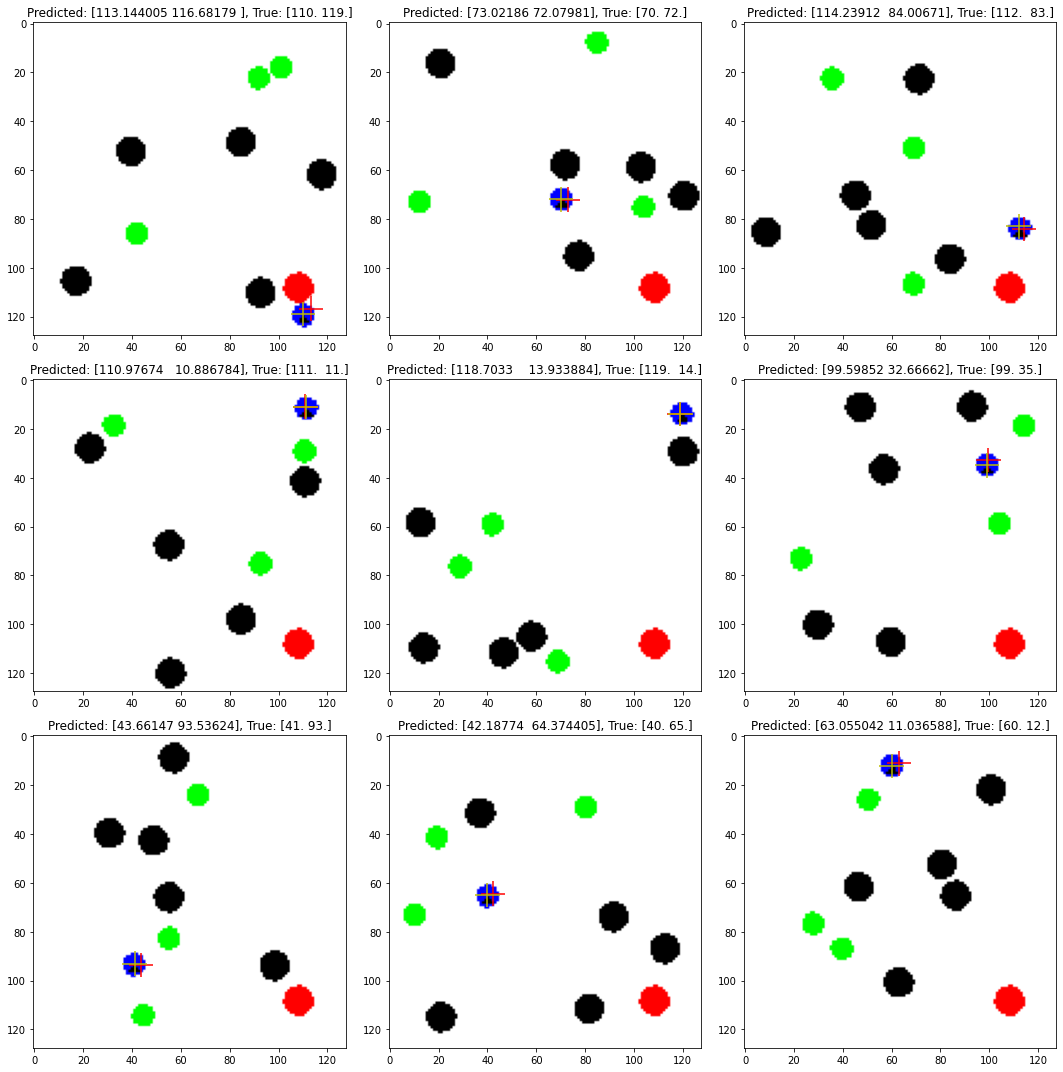

In [48]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for pos, i in enumerate(np.random.randint(0, 10000, size=9, dtype=int)):
    sample = dataset[i][0].unsqueeze(0)
    label = dataset[i][1]
    prediction = model.forward(sample)
    prediction = prediction[0].detach().numpy()[0]

    ax[pos % 3][pos // 3].axes.imshow(sample[0].numpy().transpose(1, 2, 0))
    ax[pos % 3][pos // 3].set_title(f"Predicted: {prediction}, True: {label.numpy()}")
    # cross-hair on predicted position
    x, y = prediction
    ax[pos % 3][pos // 3].axes.vlines(x, y-5, y+5, color="r")
    ax[pos % 3][pos // 3].axes.hlines(y, x-5, x+5, color="r")
    # cross-hair on true positon
    x, y = label
    ax[pos % 3][pos // 3].axes.vlines(x, y-5, y+5, color="y")
    ax[pos % 3][pos // 3].axes.hlines(y, x-5, x+5, color="y")
plt.tight_layout()
plt.show()